<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Prediction using Numerical and Textual Analysis


## Import the necessary modules, BSESN and News-Headlines data

In [1]:
import pandas as pd
import numpy as np
from numpy import concatenate
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /home/nouaim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/nouaim/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/home/nouaim/sparks/project5/venv/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Visualize stock data

In [2]:
df_prices = pd.read_csv('data/BSESN.csv')
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0
...,...,...,...,...,...,...,...
247,2021-01-08,48464.910156,48854.339844,48365.578125,48782.511719,48782.511719,22200.0
248,2021-01-11,49252.308594,49303.789063,48956.378906,49269.320313,49269.320313,21200.0
249,2021-01-12,49228.261719,49569.140625,49079.570313,49517.109375,49517.109375,12700.0
250,2021-01-13,49763.929688,49795.191406,49073.851563,49492.320313,49492.320313,27200.0


Text(0.5, 1.0, 'BSESN')

<Figure size 72x0 with 0 Axes>

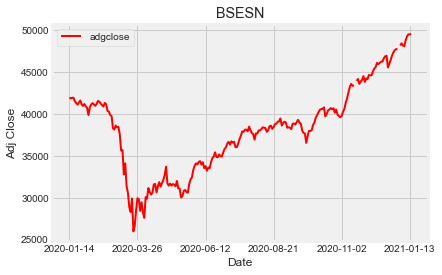

In [3]:
# Historical graph for the closing price
import matplotlib.pyplot as plt
plt.figure(figsize=(1, 0))
df_prices.plot(x='Date', y='Adj Close',label="adgclose",color="Red", linewidth=2, markersize=10)
plt.ylabel('Adj Close')
plt.xlabel("Date")
plt.title("BSESN")

Text(0.5, 1.0, 'BSESN')

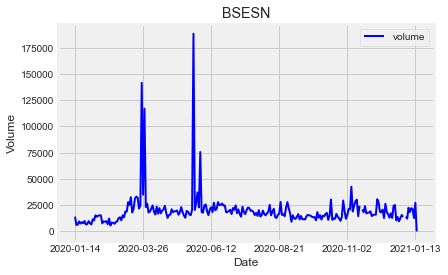

In [4]:
# Plot the total volume of stock being traded each day
df_prices.plot(x='Date', y='Volume',label="volume",color="Blue", linewidth=2, markersize=10)
plt.ylabel('Volume')
plt.xlabel("Date")
plt.title("BSESN")

array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>],
       [<AxesSubplot:title={'center':'Low'}>,
        <AxesSubplot:title={'center':'Close'}>],
       [<AxesSubplot:title={'center':'Adj Close'}>,
        <AxesSubplot:title={'center':'Volume'}>]], dtype=object)

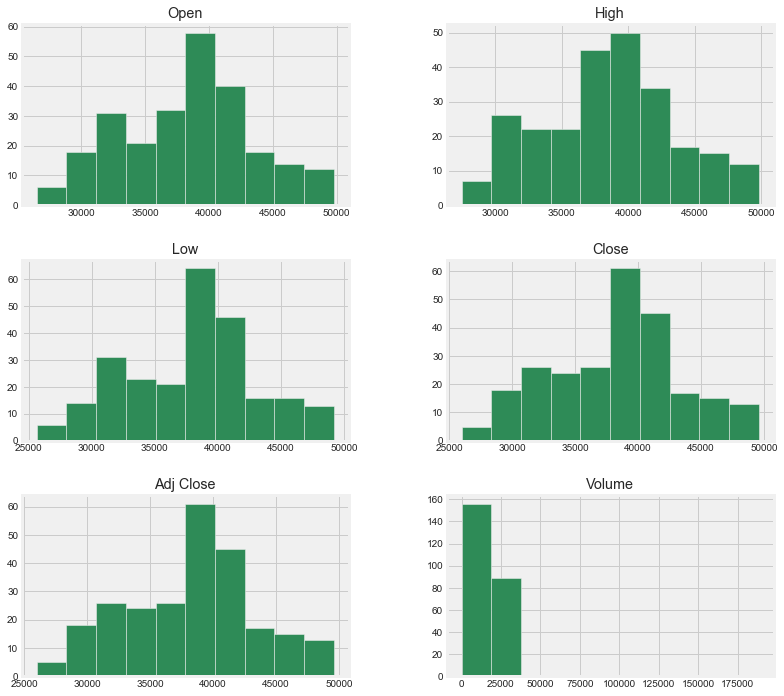

In [5]:
df_prices.hist(figsize=(12, 12),color='seagreen')

### Visualize News data

In [6]:
cols = ['Date','Category','News']
df_news = pd.read_csv('data/india-news-headlines.csv', names = cols)
df_news = df_news.dropna(axis = 0, how ='any') 
df_news.head()

,Date,Category,News
0,20200101,life-style.events,Happy New Year 2020: Images; Quotes; Wishes; M...
1,20200101,city.bhubaneswar,Bone-clling cold wavecontinues to sweep state
2,20200101,city.hyderabad,T gained 163 sq km forest cover
3,20200101,city.hyderabad,Draft electoral rolls published
4,20200101,city.koc,Invasive species increasing in Kerala's core f...


## Cleaning and Pre-processing

In [7]:
# Dropping None values, and the Category column as they are not required for the analysis.
df_news.drop(0, inplace=True)
df_news.drop('Category', axis = 1, inplace=True)

In [8]:
# Converting 'Date' columns from both dataframes to type datetime
df_news['Date'] = pd.to_datetime(df_news['Date'],format= '%Y%m%d')
df_news.head()

,Date,News
1,2020-01-01,Bone-clling cold wavecontinues to sweep state
2,2020-01-01,T gained 163 sq km forest cover
3,2020-01-01,Draft electoral rolls published
4,2020-01-01,Invasive species increasing in Kerala's core f...
5,2020-01-01,Onion price in Hyd dips to Rs 90/kg


In [9]:
df_news.shape

(90872, 2)

In [10]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'])
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-14,41883.089844,41994.261719,41770.898438,41952.628906,41952.628906,14100.0
1,2020-01-15,41969.859375,41969.859375,41648.109375,41872.730469,41872.730469,6100.0
2,2020-01-16,41924.738281,42059.449219,41812.281250,41932.558594,41932.558594,6600.0
3,2020-01-17,41929.019531,42063.929688,41850.289063,41945.371094,41945.371094,9500.0
4,2020-01-20,42263.000000,42273.871094,41503.371094,41528.910156,41528.910156,7500.0


In [11]:
df_prices.shape

(252, 7)

In [12]:
df_news['News'] = df_news.groupby(['Date']).transform(lambda x : ' '.join(x)) 
df_news = df_news.drop_duplicates() 
df_news.reset_index(inplace = True, drop = True)
df_news.shape

(182, 2)

In [13]:
# Cleaning the headlines
clean = []

for i in range(0,len(df_news['News'])):
    news = re.sub('[^a-zA-Z]',' ',df_news['News'][i])
    news = news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in set(stopwords.words('english'))]
    news=' '.join(news)
    clean.append(news)    

In [14]:
df_news['News'] = pd.Series(clean)
df_news.head()

,Date,News
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...
1,2020-01-02,horoscop today januari read predict ari tauru ...
2,2020-01-03,bank holiday mazya navryac bayko updat januari...
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...
4,2020-01-05,home beauti blue live diet induc sound sleep y...


## Calculating Subjectivity and Polarity scores with TextBlob

In [15]:
# Defining subjectivity and polarity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
  return  TextBlob(text).sentiment.polarity

In [16]:
# Inserting subjectivity and polarity columns
df_news['Subjectivity'] = df_news['News'].apply(getSubjectivity)
df_news['Polarity'] = df_news['News'].apply(getPolarity)
df_news.head()

,Date,News,Subjectivity,Polarity
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071


## Sentimental Analysis for News Headlines

In [17]:
#Adding sentiment score to df_news
sia = SentimentIntensityAnalyzer()

df_news['Compound'] = [sia.polarity_scores(v)['compound'] for v in df_news['News']]
df_news['Negative'] = [sia.polarity_scores(v)['neg'] for v in df_news['News']]
df_news['Neutral'] = [sia.polarity_scores(v)['neu'] for v in df_news['News']]
df_news['Positive'] = [sia.polarity_scores(v)['pos'] for v in df_news['News']]
df_news.head()

,Date,News,Subjectivity,Polarity,Compound,Negative,Neutral,Positive
0,2020-01-01,bone clling cold wavecontinu sweep state gain ...,0.407322,0.040349,-0.9998,0.151,0.777,0.071
1,2020-01-02,horoscop today januari read predict ari tauru ...,0.410638,0.078692,-0.9998,0.155,0.766,0.079
2,2020-01-03,bank holiday mazya navryac bayko updat januari...,0.370711,0.085875,-0.9994,0.122,0.790,0.088
3,2020-01-04,mamta mohanda play nurs lalbagh tolli celeb op...,0.389496,0.126830,-0.9998,0.146,0.780,0.074
4,2020-01-05,home beauti blue live diet induc sound sleep y...,0.350895,0.093071,-0.9999,0.156,0.772,0.072


## Use Sentimental Analysis predictions +  historical prices data to predict stock prices using Multivariate Time Series Forecasting

In [18]:
# Merging our findings (the updated News dataframe) with the Prices dataframe
df_merge = pd.merge(df_prices, df_news, how='inner', on='Date')
print(df_prices)
df_merge.drop('Date', axis = 1, inplace=True)
df_merge.drop('News', axis=1, inplace=True)

          Date          Open          High           Low         Close  \
0   2020-01-14  41883.089844  41994.261719  41770.898438  41952.628906   
1   2020-01-15  41969.859375  41969.859375  41648.109375  41872.730469   
2   2020-01-16  41924.738281  42059.449219  41812.281250  41932.558594   
3   2020-01-17  41929.019531  42063.929688  41850.289063  41945.371094   
4   2020-01-20  42263.000000  42273.871094  41503.371094  41528.910156   
..         ...           ...           ...           ...           ...   
247 2021-01-08  48464.910156  48854.339844  48365.578125  48782.511719   
248 2021-01-11  49252.308594  49303.789063  48956.378906  49269.320313   
249 2021-01-12  49228.261719  49569.140625  49079.570313  49517.109375   
250 2021-01-13  49763.929688  49795.191406  49073.851563  49492.320313   
251 2021-01-14  49432.828125  49663.578125  49182.371094  49584.160156   

        Adj Close   Volume  
0    41952.628906  14100.0  
1    41872.730469   6100.0  
2    41932.558594   6600

In [19]:
print(df_merge.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Subjectivity',
       'Polarity', 'Compound', 'Negative', 'Neutral', 'Positive'],
      dtype='object')


In [20]:
# Getting data series ready for Multivariate Time Series Forecasting
from pandas import DataFrame as df
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df1 = df(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df1.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df1.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
# scale the data for optimal performance
values = df_merge.values
print(df_merge)
print(values)
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[12,13,14,16,17,18,19,20,21,22,23]], axis=1, inplace=True)
print(reframed.columns)

             Open          High           Low         Close     Adj Close  \
0    41883.089844  41994.261719  41770.898438  41952.628906  41952.628906   
1    41969.859375  41969.859375  41648.109375  41872.730469  41872.730469   
2    41924.738281  42059.449219  41812.281250  41932.558594  41932.558594   
3    41929.019531  42063.929688  41850.289063  41945.371094  41945.371094   
4    42263.000000  42273.871094  41503.371094  41528.910156  41528.910156   
..            ...           ...           ...           ...           ...   
108  35679.738281  35706.550781  34794.929688  34868.980469  34868.980469   
109  34525.390625  35081.609375  34499.781250  34842.101563  34842.101563   
110  35144.781250  35254.878906  34910.339844  35171.269531  35171.269531   
111  34926.949219  35032.359375  34662.058594  34961.519531  34961.519531   
112  35168.300781  35233.910156  34812.800781  34915.800781  34915.800781   

      Volume  Subjectivity  Polarity  Compound  Negative  Neutral  Positive

### Building a **LSTM** **(Long Short Term Memory)** model to predict Stock Prices

In [22]:
# split into train and test sets
values = reframed.values
print((values).shape)
n_train_hours = 90
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(112, 13)
(90, 1, 12) (90,) (22, 1, 12) (22,)


/home/nouaim/sparks/project5/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nouaim/sparks/project5/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nouaim/sparks/project5/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nouaim/sparks/project5/venv/lib/python3.6/s

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 90 samples, validate on 22 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
90/90 - 2s - loss: 0.5813 - val_loss: 0.5111
Epoch 2/50
90/90 - 0s - loss: 0.5495 - val_loss: 0.4809
Epoch 3/50
90/90 - 0s - loss: 0.5181 - val_loss: 0.4507
Epoch 4/50
90/90 - 0s - loss: 0.4868 - val_loss: 0.4205
Epoch 5/50
90/90 - 0s - loss: 0.4556 - val_loss: 0.3901
Epoch 6/50
90/90 - 0s - loss: 0.4245 - val_loss: 0.3594
Epoch 7/50
90/90 - 0s - loss: 0.3934 - val_loss: 0.3285
Epoch 8/50
90/90 - 0s - loss: 0.3630 - val_loss: 0.2972
Epoch 9/50
90/90 - 0s - loss: 0.3331 - val_loss: 0.2656
Epoch 10/50
90/90 - 0s - loss: 0.3033 - val_loss: 0.2335
Epoch 11/50
90/90 - 0s - loss: 0.2730 - val_loss: 0.2008
Epoch 12/50
90/90 - 0s - loss: 0.2437 - val_loss: 0.1681
Epoch 13/50
90/90 - 0s - loss: 0.2186 - val_loss: 0.1362
Epoch 14/50


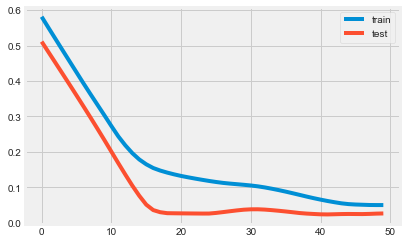

In [23]:
# design the network
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam') 

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Evaluation of the LSTM model using test data by calculating **RMSE(Root Mean Square Error)**

In [24]:
# make a prediction
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[2]))
print(test_X.shape)
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


(22, 1, 12)
(22, 1, 12)
Test RMSE: 511.997


#  RMSE of **511**, i.e predicted prices can be off by 511 units 
## This is a good RMSE, considering the sensex prices are in the order of 4 (for eg, around 48k units). 